## Baseline mnist deep classifier


In [1]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.optim as optim

In [2]:
# @title
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7744, 1028)
        self.fc2 = nn.Linear(1028, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output



In [3]:
# @title
torch.manual_seed(42)
has_gpu = torch.cuda.is_available()
device = torch.device("cuda" if has_gpu else "cpu")
batch_size = 128
lr = 1e-4
epochs = 10

In [4]:
# @title
model = MNISTNet()
model = model.to(device)
dataset = datasets.MNIST(root = 'data/', download = True,
                         transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_data, test_data = random_split(dataset, [50000, 10000])
train_loader = DataLoader(train_data, batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size, shuffle = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 150094987.81it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39599769.15it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 141008265.64it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5769390.90it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
# @title
def train(optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



def test_baseline(tmodel):
    tmodel.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = tmodel(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [6]:
# @title
optimizer = optim.Adam(model.parameters(), lr=lr)

test_accuracy = []
for epoch in range(1, epochs + 1):
    train(optimizer, epoch)
    test_acc = test_baseline(model)
    test_accuracy.append(test_acc)

torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303411
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.565737
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.425389
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.427359
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.288868
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.183990
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.219224
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.280917

Test set: Average loss: 0.1387, Accuracy: 9571/10000 (95.7100%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.108588
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.139148
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.139504
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.062080
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.176368
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.117320
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.054192
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.155932

Test set: Average loss: 0.0757, Accuracy: 9763/10000 (97.6300%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.085022
Train Epoch: 3 [6400/50000 (13%)]	L

Text(0.5, 1.0, 'Baseline cnn')

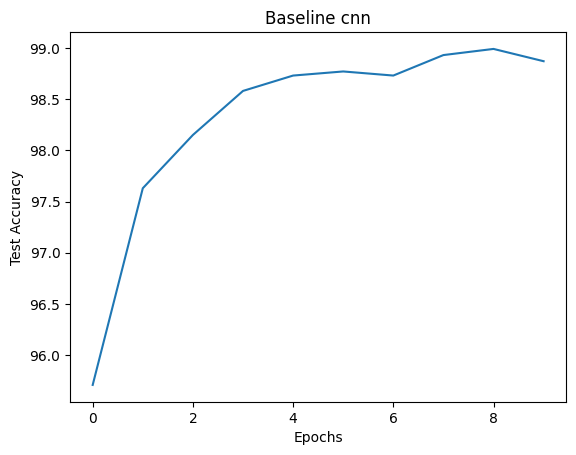

In [7]:
# @title
import matplotlib.pyplot as plt
plt.plot(range(epochs), test_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Baseline cnn")

## FGSM based untargeted attack on the trained model using test dataset and varying values of $\epsilon_i$

In [8]:
# @title
epsilons = [.2, .25, .3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
# pretrained_model = "mnist_cnn.pt"

###
# Reference : https://pytorch.org/tutorials/beginner/fgsm_tutorial.html#fgsm-attack for below mentioned functions denorm and fgsm_attack
###

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):

    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)


def untargeted_fgsm_test(tmodel, epsilon):
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = tmodel(data)
        init_pred = output.max(1, keepdim=True)[1].squeeze()
        # print(init_pred.shape)
        # print(target.shape)
        if torch.all(torch.eq(init_pred, target)):
            continue

        loss = F.nll_loss(output, target)

        tmodel.zero_grad()

        loss.backward()
        data_grad = data.grad.data
        data_denorm = denorm(data)
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        output = tmodel(perturbed_data_normalized)

        # Check for successx
        final_pred = output.max(1, keepdim=True)[1].squeeze()
        correct += torch.eq(final_pred, target).float().sum()


    final_acc = correct/float(len(test_loader.dataset))
    attack_success = 1 - correct/float(len(test_loader.dataset))

    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader.dataset)} = {final_acc}\tAttack Success: {attack_success*100}%")


    return final_acc, attack_success

In [9]:
# @title
accuracies = []
attack_rates = []
model.eval()
# Run test for each epsilon
for eps in epsilons:
    acc, attack_rate = untargeted_fgsm_test(model, eps)
    accuracies.append(acc)
    attack_rates.append(attack_rate)

Epsilon: 0.2	Test Accuracy = 3827.0 / 10000 = 0.38269999623298645	Attack Success: 61.730003356933594%
Epsilon: 0.25	Test Accuracy = 2309.0 / 10000 = 0.23089998960494995	Attack Success: 76.91000366210938%
Epsilon: 0.3	Test Accuracy = 1507.0 / 10000 = 0.15070000290870667	Attack Success: 84.93000030517578%
Epsilon: 0.35	Test Accuracy = 1085.0 / 10000 = 0.10849999636411667	Attack Success: 89.1500015258789%
Epsilon: 0.4	Test Accuracy = 813.0 / 10000 = 0.08129999786615372	Attack Success: 91.8699951171875%
Epsilon: 0.45	Test Accuracy = 649.0 / 10000 = 0.0648999959230423	Attack Success: 93.51000213623047%
Epsilon: 0.5	Test Accuracy = 576.0 / 10000 = 0.0575999990105629	Attack Success: 94.23999786376953%
Epsilon: 0.6	Test Accuracy = 551.0 / 10000 = 0.05509999766945839	Attack Success: 94.48999786376953%
Epsilon: 0.7	Test Accuracy = 614.0 / 10000 = 0.061400000005960464	Attack Success: 93.86000061035156%
Epsilon: 0.8	Test Accuracy = 701.0 / 10000 = 0.07009999454021454	Attack Success: 92.98999786376

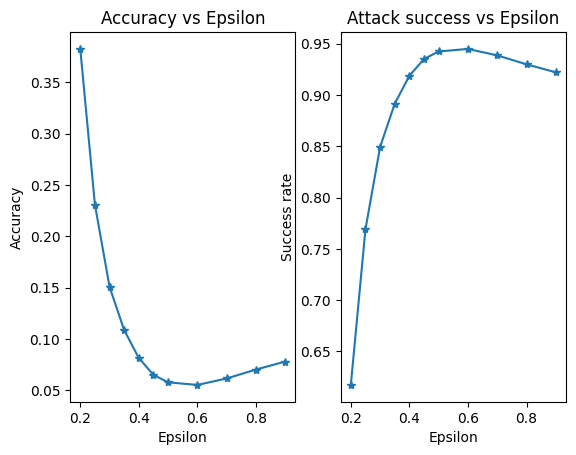

<Figure size 1200x600 with 0 Axes>

In [10]:
# @title
fig, axs = plt.subplots(1, 2)

plt.figure(figsize=(12,6))
axs[0].plot(epsilons, torch.tensor(accuracies).squeeze().cpu().numpy(), "*-")
axs[0].set_title("Accuracy vs Epsilon")
axs[0].set_xlabel("Epsilon")
axs[0].set_ylabel("Accuracy")

axs[1].plot(epsilons, torch.tensor(attack_rates).squeeze().cpu().numpy(), "*-")
axs[1].set_title("Attack success vs Epsilon")
axs[1].set_xlabel("Epsilon")
axs[1].set_ylabel("Success rate")

plt.show()

## Targeted FGSM

In [11]:
# @title
def targeted_fsgm_test(tmodel, epsilon):
    correct = 0
    attack_success = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = tmodel(data)
        init_pred = output.max(1, keepdim=True)[1].squeeze()
        # print(init_pred.shape)
        # print(target.shape)
        if torch.all(torch.eq(init_pred, target)):
            continue

        loss = F.nll_loss(output, target)

        tmodel.zero_grad()

        loss.backward()
        data_grad = data.grad.data
        data_denorm = denorm(data)
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        output = tmodel(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1].squeeze()
        correct += torch.eq(final_pred, target).float().sum()

        # check for targeted
        attack_target = torch.add(target, 1).fmod(10)
        attack_success += torch.eq(final_pred, attack_target).float().sum()

    final_acc = correct/float(len(test_loader.dataset))
    attack_rate = attack_success/float(len(test_loader.dataset))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader.dataset)} = {final_acc}\tAttack Success: {attack_rate*100}%")

    return final_acc, attack_rate

accuracies = []
attack_rates = []
model.eval()
# Run test for each epsilon
for eps in epsilons:
    acc, attack_rate = targeted_fsgm_test(model, eps)
    accuracies.append(acc)
    attack_rates.append(attack_rate)

accuracies = torch.tensor(accuracies).squeeze()


Epsilon: 0.2	Test Accuracy = 3827.0 / 10000 = 0.38269999623298645	Attack Success: 3.5099997520446777%
Epsilon: 0.25	Test Accuracy = 2309.0 / 10000 = 0.23089998960494995	Attack Success: 5.749999523162842%
Epsilon: 0.3	Test Accuracy = 1507.0 / 10000 = 0.15070000290870667	Attack Success: 7.62999963760376%
Epsilon: 0.35	Test Accuracy = 1085.0 / 10000 = 0.10849999636411667	Attack Success: 9.119998931884766%
Epsilon: 0.4	Test Accuracy = 813.0 / 10000 = 0.08129999786615372	Attack Success: 10.109999656677246%
Epsilon: 0.45	Test Accuracy = 649.0 / 10000 = 0.0648999959230423	Attack Success: 10.819999694824219%
Epsilon: 0.5	Test Accuracy = 576.0 / 10000 = 0.0575999990105629	Attack Success: 11.109999656677246%
Epsilon: 0.6	Test Accuracy = 551.0 / 10000 = 0.05509999766945839	Attack Success: 11.09999942779541%
Epsilon: 0.7	Test Accuracy = 614.0 / 10000 = 0.061400000005960464	Attack Success: 10.920000076293945%
Epsilon: 0.8	Test Accuracy = 701.0 / 10000 = 0.07009999454021454	Attack Success: 10.489999

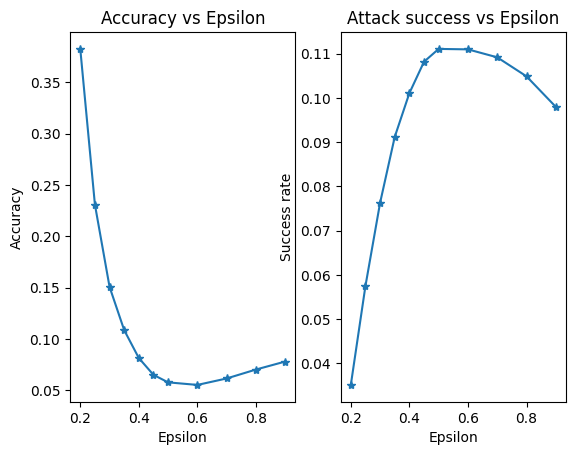

<Figure size 1200x600 with 0 Axes>

In [12]:
# @title
fig, axs = plt.subplots(1, 2)

plt.figure(figsize=(12,6))
axs[0].plot(epsilons, accuracies.cpu().numpy(), "*-")
axs[0].set_title("Accuracy vs Epsilon")
axs[0].set_xlabel("Epsilon")
axs[0].set_ylabel("Accuracy")

axs[1].plot(epsilons, torch.tensor(attack_rates).squeeze().cpu().numpy(), "*-")
axs[1].set_title("Attack success vs Epsilon")
axs[1].set_xlabel("Epsilon")
axs[1].set_ylabel("Success rate")

plt.show()

## Retraining model with adversarial samples

In [13]:
# @title
def train_adversarial(epsilon, optimizer, epoch):
    adversarial_model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        optimizer.zero_grad()
        output = adversarial_model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        data_grad = data.grad.data

        data_denorm = denorm(data)
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        optimizer.zero_grad()
        output1 = adversarial_model(perturbed_data_normalized)
        loss1 = F.nll_loss(output1, target)
        loss1.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data) * 2, len(train_loader.dataset)*2,
                100. * batch_idx / len(train_loader), loss.item() + loss1.item()))


In [14]:
# @title
epsilon = 125/255
test_accuracy = []
adversarial_model = MNISTNet()
adversarial_model.to(device)
adversarial_model.train()

optimizer = optim.Adam(adversarial_model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train_adversarial(epsilon, optimizer, epoch)
    test_acc = test_baseline(adversarial_model)
    test_accuracy.append(test_acc)

Train Epoch: 1 [0/100000 (0%)]	Loss: 4.617422
Train Epoch: 1 [12800/100000 (13%)]	Loss: 3.171353
Train Epoch: 1 [25600/100000 (26%)]	Loss: 1.973788
Train Epoch: 1 [38400/100000 (38%)]	Loss: 1.591483
Train Epoch: 1 [51200/100000 (51%)]	Loss: 0.990069
Train Epoch: 1 [64000/100000 (64%)]	Loss: 1.100634
Train Epoch: 1 [76800/100000 (77%)]	Loss: 0.619135
Train Epoch: 1 [89600/100000 (90%)]	Loss: 0.978786

Test set: Average loss: 0.1052, Accuracy: 9699/10000 (96.9900%)

Train Epoch: 2 [0/100000 (0%)]	Loss: 0.816198
Train Epoch: 2 [12800/100000 (13%)]	Loss: 0.802245
Train Epoch: 2 [25600/100000 (26%)]	Loss: 0.782809
Train Epoch: 2 [38400/100000 (38%)]	Loss: 1.005673
Train Epoch: 2 [51200/100000 (51%)]	Loss: 1.136698
Train Epoch: 2 [64000/100000 (64%)]	Loss: 0.858414
Train Epoch: 2 [76800/100000 (77%)]	Loss: 0.697209
Train Epoch: 2 [89600/100000 (90%)]	Loss: 0.694043

Test set: Average loss: 0.0693, Accuracy: 9782/10000 (97.8200%)

Train Epoch: 3 [0/100000 (0%)]	Loss: 0.816644
Train Epoch: 3 [

## Untargeted FGSM on adversarially trained model

In [15]:
# @title
accuracies = []
attack_rates = []
adversarial_model.eval()
# Run test for each epsilon
for eps in epsilons:
    acc, attack_rate = untargeted_fgsm_test(adversarial_model, eps)
    accuracies.append(acc)
    attack_rates.append(attack_rate)

Epsilon: 0.2	Test Accuracy = 6461.0 / 10000 = 0.6460999846458435	Attack Success: 35.3900032043457%
Epsilon: 0.25	Test Accuracy = 6706.0 / 10000 = 0.6705999970436096	Attack Success: 32.939998626708984%
Epsilon: 0.3	Test Accuracy = 6943.0 / 10000 = 0.6942999958992004	Attack Success: 30.56999969482422%
Epsilon: 0.35	Test Accuracy = 7106.0 / 10000 = 0.710599958896637	Attack Success: 28.940004348754883%
Epsilon: 0.4	Test Accuracy = 7226.0 / 10000 = 0.722599983215332	Attack Success: 27.740001678466797%
Epsilon: 0.45	Test Accuracy = 7298.0 / 10000 = 0.7297999858856201	Attack Success: 27.020000457763672%
Epsilon: 0.5	Test Accuracy = 7331.0 / 10000 = 0.7330999970436096	Attack Success: 26.690000534057617%
Epsilon: 0.6	Test Accuracy = 7357.0 / 10000 = 0.7356999516487122	Attack Success: 26.430004119873047%
Epsilon: 0.7	Test Accuracy = 7254.0 / 10000 = 0.7253999710083008	Attack Success: 27.460002899169922%
Epsilon: 0.8	Test Accuracy = 6907.0 / 10000 = 0.6906999945640564	Attack Success: 30.930000305

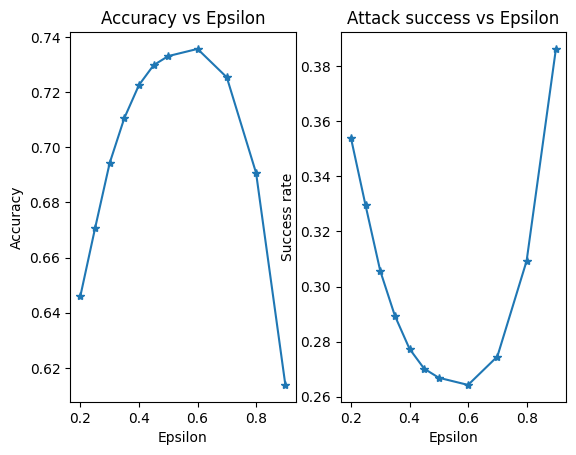

<Figure size 1200x600 with 0 Axes>

In [16]:
# @title
fig, axs = plt.subplots(1, 2)
plt.title('Untargeted FGSM on adversarially trained')
plt.figure(figsize=(12,6))
axs[0].plot(epsilons, torch.tensor(accuracies).squeeze().cpu().numpy(), "*-")
axs[0].set_title("Accuracy vs Epsilon")
axs[0].set_xlabel("Epsilon")
axs[0].set_ylabel("Accuracy")

axs[1].plot(epsilons, torch.tensor(attack_rates).squeeze().cpu().numpy(), "*-")
axs[1].set_title("Attack success vs Epsilon")
axs[1].set_xlabel("Epsilon")
axs[1].set_ylabel("Success rate")

plt.show()

### We can see that the model becomes robust against untargeted FGSM attack as the success rate decreases from ~70-90% to ~25-40% for different values of epsilon. The curve of success rate is U shaped, as till the epsilon value for which we trained the model to defend the attack, we are able to decrease the success rates for the attack and it's the least for value around .5, that is the value for which we had trained for and then it increases for higher values of epsilon